In [1]:
import os
import numpy as np
import jams
from scipy.io import wavfile
import sys
import librosa
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [18]:
annotation_folder = "audio/GuitarSet/annotation/"
audio_folder = "audio/GuitarSet/audio/"
output = {}
hop_length = 512
sr_curr = 22050
cqt_n_bins = 288
cqt_bins_per_octave = 36
string_midi_pitches = [40,45,50,55,59,64]
highest_fret = 19
num_classes = highest_fret + 2
matrix = np.zeros(shape=(6, 21)).astype(int)

In [3]:
def preprocess_audio(data):
    data = data.astype(float)
    data = librosa.util.normalize(data)
    data = np.abs(librosa.cqt(data,
                              hop_length=hop_length,
                              sr=sr_curr,
                              n_bins=cqt_n_bins,
                              bins_per_octave=cqt_bins_per_octave))

    return data

In [4]:
def correct_numbering(n):
    n += 1
    if n < 0 or n > highest_fret+1:
        n = 0
    return n

def categorical(label):
    return to_categorical(label, num_classes)

In [5]:
def clean_label(label):
    label = [correct_numbering(n) for n in label]
    return categorical(label)

In [6]:
def clean_labels(labels):
    return np.array([clean_label(label) for label in labels])

In [23]:
def load_rep_and_labels_from_raw_file(filename):
    output = {}
    file_audio = audio_folder + filename + "_mic.wav"
    file_anno = annotation_folder + filename + ".jams"
    jam = jams.load(file_anno)
    data, _ = librosa.load(file_audio, sr=sr_curr)

    # preprocess audio, store in output dict
    output["repr"] = np.swapaxes(preprocess_audio(data),0,1)

    # construct labels
    frame_indices = range(len(output["repr"]))
    times = librosa.frames_to_time(frame_indices, sr = sr_curr, hop_length=hop_length)

    # loop over all strings and sample annotations
    labels = []
    for string_num in range(6):
        anno = jam.annotations["note_midi"][string_num]
        string_label_samples = anno.to_samples(times)
        # replace midi pitch values with fret numbers
        for i in frame_indices:
            if string_label_samples[i] == []:
                string_label_samples[i] = -1
            else:
                string_label_samples[i] = int(round(string_label_samples[i][0]) - string_midi_pitches[string_num])
        labels.append([string_label_samples])

    labels = np.array(labels)
    # remove the extra dimension
    labels = np.squeeze(labels)
    labels = np.swapaxes(labels,0,1)

    # clean labels
    labels = clean_labels(labels)

    # store and return
    output["labels"] = labels
    labels = labels.astype(int)
    sum_labels = np.zeros((6, 21)).astype(int)
    for label in labels:
        sum_labels += label
    return sum_labels

In [24]:
for file in os.listdir(annotation_folder):
    file = file.replace('.jams', '')
    l = load_rep_and_labels_from_raw_file(file)
    matrix += l
    print(f"file {file} done")

file 00_BN1-129-Eb_comp done
file 00_BN1-129-Eb_solo done
file 00_BN1-147-Gb_comp done
file 00_BN1-147-Gb_solo done
file 00_BN2-131-B_comp done
file 00_BN2-131-B_solo done
file 00_BN2-166-Ab_comp done
file 00_BN2-166-Ab_solo done
file 00_BN3-119-G_comp done
file 00_BN3-119-G_solo done
file 00_BN3-154-E_comp done
file 00_BN3-154-E_solo done
file 00_Funk1-114-Ab_comp done
file 00_Funk1-114-Ab_solo done
file 00_Funk1-97-C_comp done
file 00_Funk1-97-C_solo done
file 00_Funk2-108-Eb_comp done
file 00_Funk2-108-Eb_solo done
file 00_Funk2-119-G_comp done
file 00_Funk2-119-G_solo done
file 00_Funk3-112-C#_comp done
file 00_Funk3-112-C#_solo done
file 00_Funk3-98-A_comp done
file 00_Funk3-98-A_solo done
file 00_Jazz1-130-D_comp done
file 00_Jazz1-130-D_solo done
file 00_Jazz1-200-B_comp done
file 00_Jazz1-200-B_solo done
file 00_Jazz2-110-Bb_comp done
file 00_Jazz2-110-Bb_solo done
file 00_Jazz2-187-F#_comp done
file 00_Jazz2-187-F#_solo done
file 00_Jazz3-137-Eb_comp done
file 00_Jazz3-137-Eb_

In [25]:
print(matrix)

[[418053  14615  10675   9740  12328  12945   6597  11316   3871   3257
    2078   1482    115     93      0     15      0      0      0      0
       0]
 [363565   8932   5291  15839  18957  24543  12273  24089  10238  12766
    4664   2590   2047   1379      7      0      0      0      0      0
       0]
 [315176  10715   2095  18815  25137  19250  17482  29689  16294  24351
    9913   9640   5188   2478    756     87     23      8     14     48
      21]
 [304914  11632  10398  15761  20814  18554  19265  31586  21998  19889
   12276  10302   5394   2231   1239    218    624     26     35     24
       0]
 [333130  11526  11673  12621  15771  17123  14691  23983  14404  18600
   12083   9362   5798   2693   2413    584    467    215     29      0
      14]
 [416324   9845   6075   6539   7594   9776   8649  11597   5374   8991
    5166   5264   2129   1961   1208    385    136    145     22      0
       0]]


In [27]:
EStringLabels = matrix[0].tolist()[1:]
AStringLabels = matrix[1].tolist()[1:]
DStringLabels = matrix[2].tolist()[1:]
GStringLabels = matrix[3].tolist()[1:]
BStringLabels = matrix[4].tolist()[1:]
eStringLabels = matrix[5].tolist()[1:]
print(f"E string: {EStringLabels}")
print(f"A string: {AStringLabels}")
print(f"D string: {DStringLabels}")
print(f"G string: {GStringLabels}")
print(f"B string: {BStringLabels}")
print(f"e string: {eStringLabels}")

E string: [14615, 10675, 9740, 12328, 12945, 6597, 11316, 3871, 3257, 2078, 1482, 115, 93, 0, 15, 0, 0, 0, 0, 0]
A string: [8932, 5291, 15839, 18957, 24543, 12273, 24089, 10238, 12766, 4664, 2590, 2047, 1379, 7, 0, 0, 0, 0, 0, 0]
D string: [10715, 2095, 18815, 25137, 19250, 17482, 29689, 16294, 24351, 9913, 9640, 5188, 2478, 756, 87, 23, 8, 14, 48, 21]
G string: [11632, 10398, 15761, 20814, 18554, 19265, 31586, 21998, 19889, 12276, 10302, 5394, 2231, 1239, 218, 624, 26, 35, 24, 0]
B string: [11526, 11673, 12621, 15771, 17123, 14691, 23983, 14404, 18600, 12083, 9362, 5798, 2693, 2413, 584, 467, 215, 29, 0, 14]
e string: [9845, 6075, 6539, 7594, 9776, 8649, 11597, 5374, 8991, 5166, 5264, 2129, 1961, 1208, 385, 136, 145, 22, 0, 0]


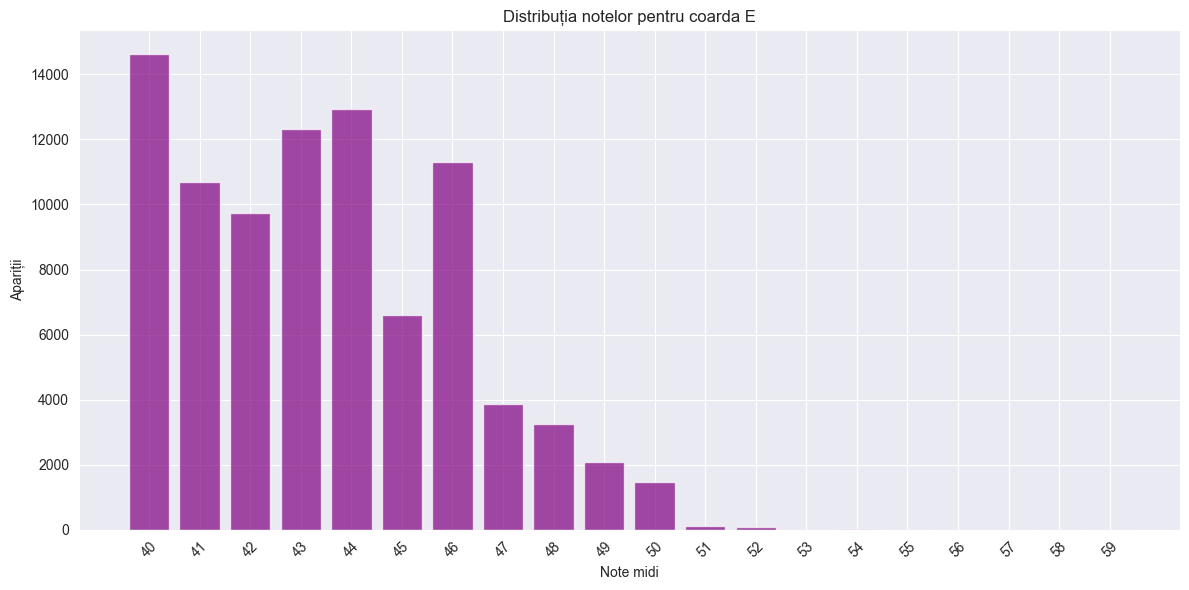

In [52]:
E_labels = [str(i) for i in range(string_midi_pitches[0], string_midi_pitches[0] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(E_labels, EStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda E')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

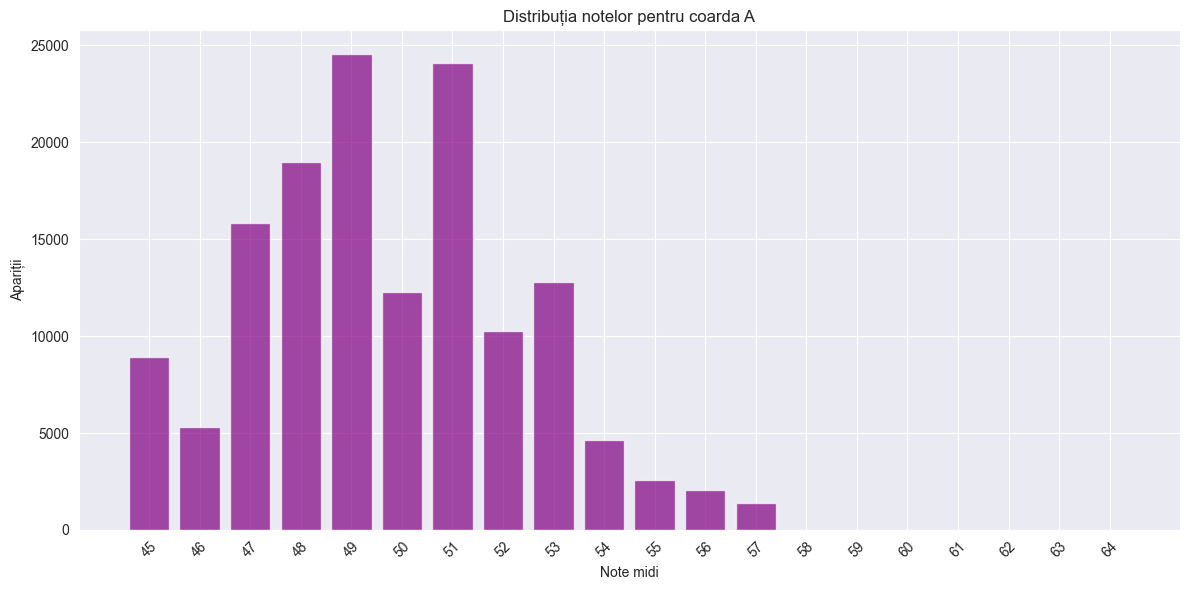

In [53]:
A_labels = [str(i) for i in range(string_midi_pitches[1], string_midi_pitches[1] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(A_labels, AStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda A')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

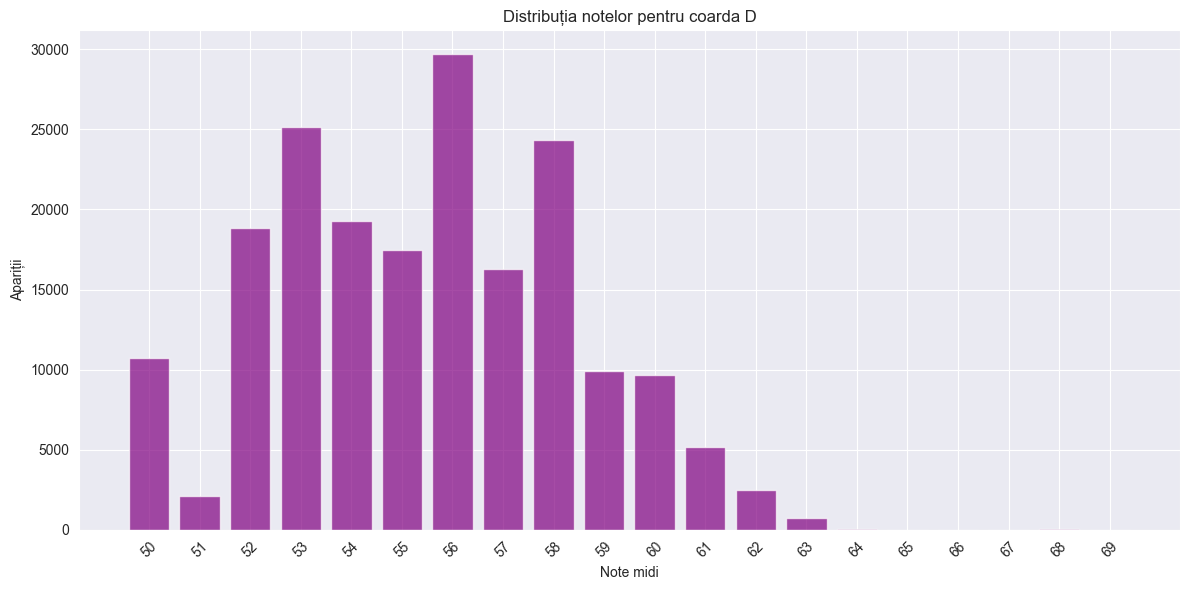

In [54]:
D_labels = [str(i) for i in range(string_midi_pitches[2], string_midi_pitches[2] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(D_labels, DStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda D')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

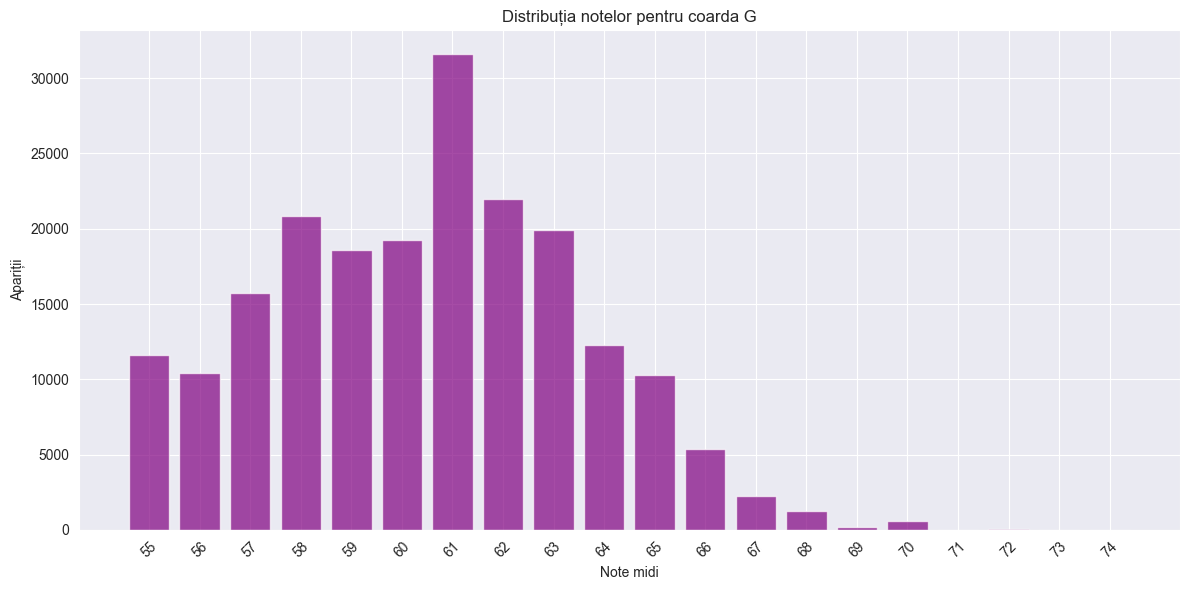

In [55]:
G_labels = [str(i) for i in range(string_midi_pitches[3], string_midi_pitches[3] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(G_labels, GStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda G')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

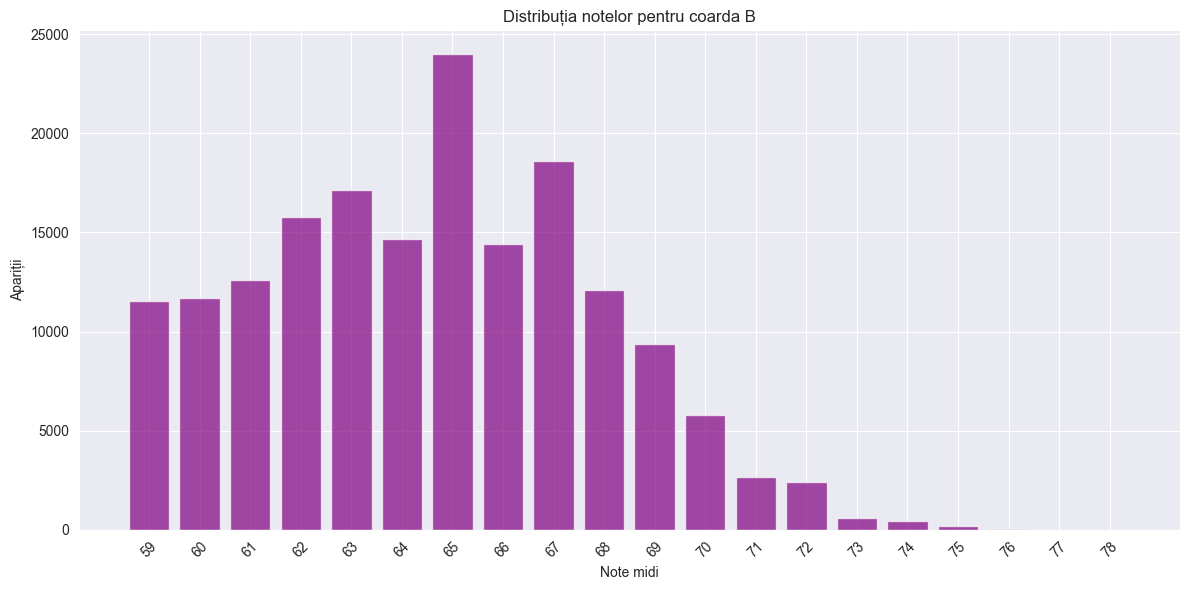

In [56]:
B_labels = [str(i) for i in range(string_midi_pitches[4], string_midi_pitches[4] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(B_labels, BStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda B')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

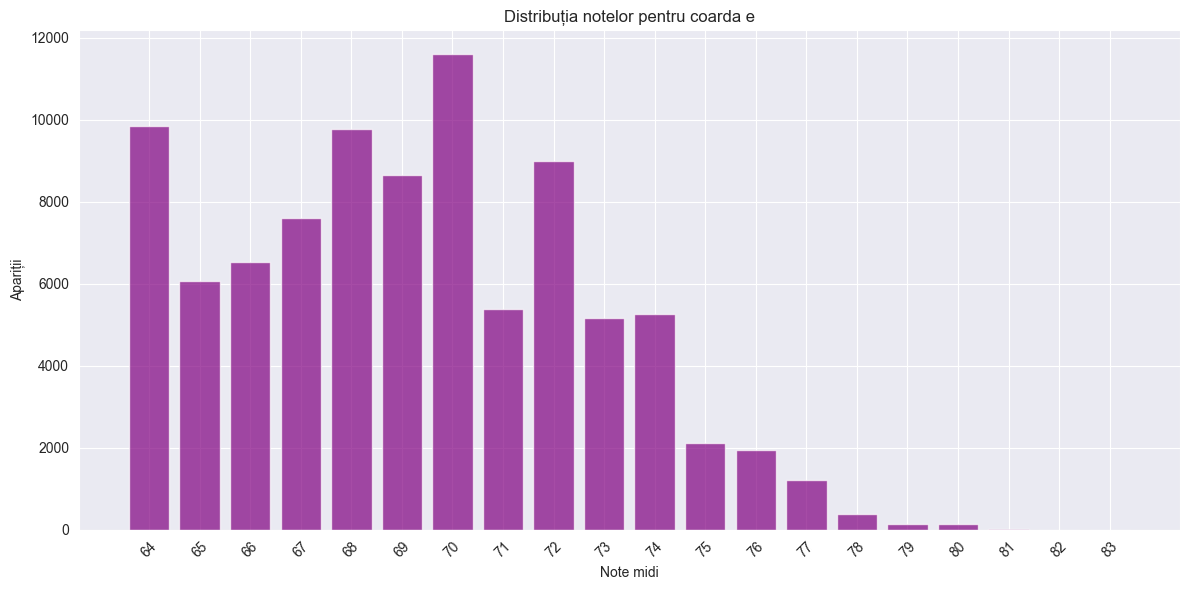

In [57]:
e_labels = [str(i) for i in range(string_midi_pitches[5], string_midi_pitches[5] + highest_fret + 1)]

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(e_labels, eStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda e')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

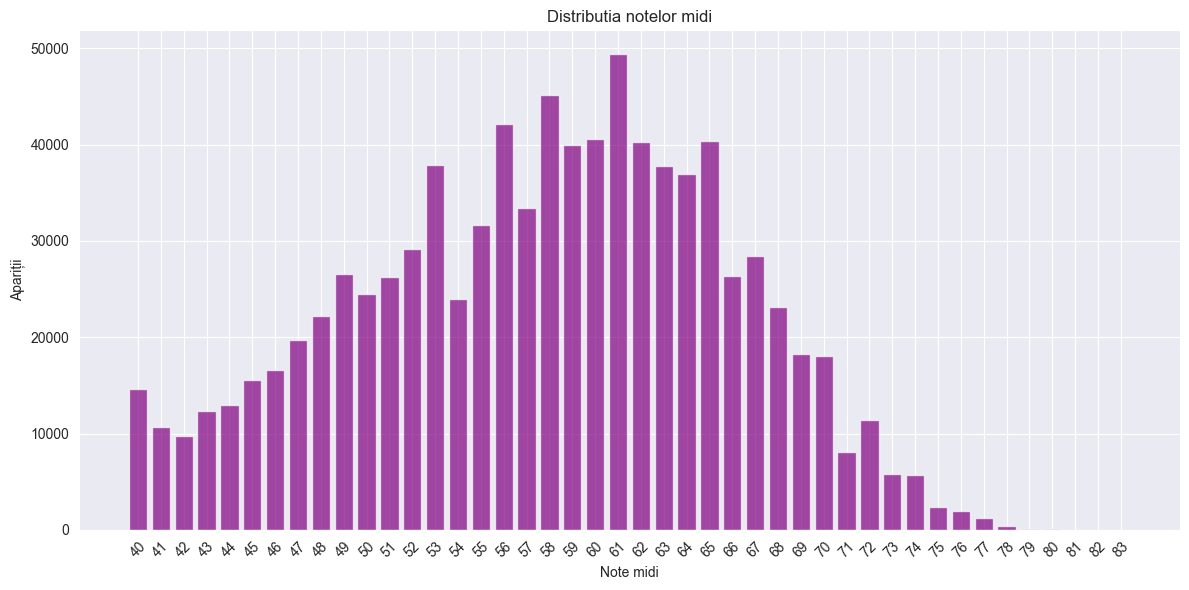

[14615.0, 10675.0, 9740.0, 12328.0, 12945.0, 15529.0, 16607.0, 19710.0, 22214.0, 26621.0, 24470.0, 26299.0, 29146.0, 37903.0, 23929.0, 31704.0, 42134.0, 33434.0, 45172.0, 39993.0, 40578.0, 49395.0, 40247.0, 37768.0, 36899.0, 40383.0, 26345.0, 28439.0, 23146.0, 18250.0, 18019.0, 8093.0, 11439.0, 5774.0, 5731.0, 2344.0, 1990.0, 1208.0, 399.0, 136.0, 145.0, 22.0, 0.0, 0.0]


In [58]:
pitch_distribution = np.zeros(44)
for string_index in range(6):
    string_distribution = matrix[string_index].tolist()[1:]
    for fret in range(0, highest_fret+1):
        pitch_distribution[string_midi_pitches[string_index] + fret - 40] += string_distribution[fret]


labels = np.array([str(i) for i in range(40, 84)])

plt.figure(figsize=(12, 6))
plt.bar(labels, pitch_distribution, color='purple', alpha=0.7)
plt.title('Distributia notelor midi')
plt.xlabel('Note midi')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

print(pitch_distribution.tolist())